In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Veri dizinleri
train_dir = "/kaggle/input/classed-odir5k-splited-into-train-test/train"
test_dir = "/kaggle/input/classed-odir5k-splited-into-train-test/test"
img_size = (224, 224)
batch_size = 64
epochs = 10  # İlk eğitim için epoch sayısı
fine_tune_epochs = 90  # Fine-tuning için ek epoch sayısı

# Veri setlerini yükle
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=True,
    seed=42
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=False
)

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

# Veri artırma (Data Augmentation) katmanları
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2)
])



# Veri setine artırma uygula
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

# Normalizasyon katmanı
preprocess_input = tf.keras.applications.vgg16.preprocess_input

# Veri setine normalizasyon uygula
train_dataset = train_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)
test_dataset = test_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)

# Veri setlerini performans için optimize et
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


Found 17555 files belonging to 8 classes.
Found 4392 files belonging to 8 classes.


In [3]:
# VGG16 modelini yükle (transfer öğrenme)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Başlangıçta katmanları dondur

# Model mimarisi
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_dataset.element_spec[1].shape[1], activation='softmax')  # Sınıf sayısı
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Modeli derle
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('vgg16_model.keras', save_best_only=True, monitor='val_accuracy')


# İlk eğitim (transfer öğrenme)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)


# Fine-tuning için bazı katmanları çözme
for layer in base_model.layers[-4:]:  # Son 4 katmanı çöz
    layer.trainable = True

# Modeli yeniden derle (daha düşük öğrenme oranı ile)
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tuning için modeli yeniden eğit
history_fine = model.fit(
    train_dataset,
    epochs=epochs + fine_tune_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 284s 971ms/step - accuracy: 0.6518 - loss: 1.4484 - val_accuracy: 0.8611 - val_loss: 0.4272
Epoch 2/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 247s 898ms/step - accuracy: 0.8207 - loss: 0.5310 - val_accuracy: 0.8648 - val_loss: 0.4009
Epoch 3/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 245s 889ms/step - accuracy: 0.8345 - loss: 0.4695 - val_accuracy: 0.8618 - val_loss: 0.3963
Epoch 4/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 245s 890ms/step - accuracy: 0.8430 - loss: 0.4470 - val_accuracy: 0.8700 - val_loss: 0.3724
Epoch 5/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 245s 891ms/step - accuracy: 0.8407 - loss: 0.4331 - val_accuracy: 0.8663 - val_loss: 0.3720
Epoch 6/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 243s 882ms/step - accuracy: 0.8421 - loss: 0.4255 - val_accuracy: 0.8673 - val_loss: 0.3698
Epoch 7/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 243s 881ms/step - accuracy: 0.8453 - loss: 0.4156 - val_accuracy: 0.8668 - val_loss: 0.3646
Epoch 8/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 246s 894ms/step - accuracy: 0.8538 -

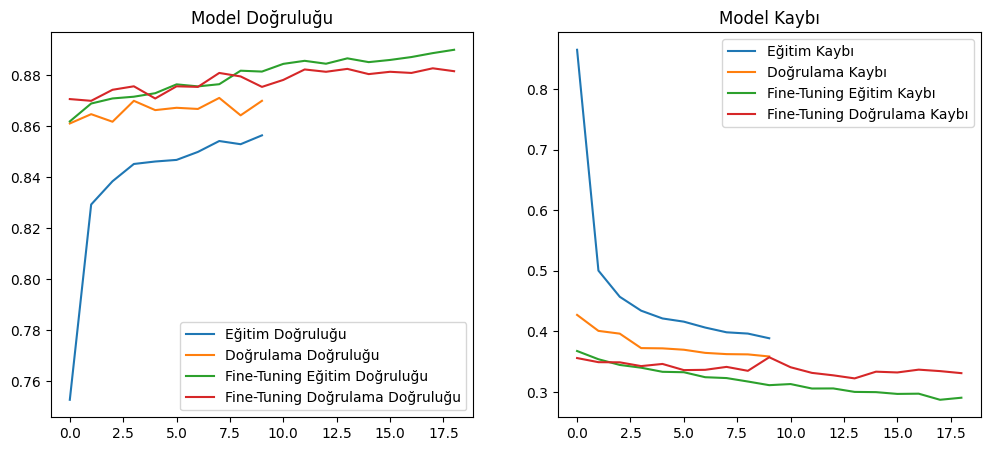

In [5]:
# Sonuçları görselleştir
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.plot(history_fine.history['accuracy'], label='Fine-Tuning Eğitim Doğruluğu')
plt.plot(history_fine.history['val_accuracy'], label='Fine-Tuning Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.plot(history_fine.history['loss'], label='Fine-Tuning Eğitim Kaybı')
plt.plot(history_fine.history['val_loss'], label='Fine-Tuning Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.legend()

plt.show()